# Fontanka for zebrafish embryogenesis

Fontanka helps you detect (call) fountains by running the fountain mask (pattern) across the genome. 
The mask can be something that you set up manually (e.g. the fountain "diamond") or an average pattern that you expect to see, e.g. example feature. 

Let's walk through fontanka step-by step:

1. Define the pattern for calling. 

    In this example, we've manually annotated fountains at chr1 and chr2 of zebrafish embryogenesis, at hte stage 5.3 hpf, when the other chromatin features are largely absent. 

2. Calculate cis-expected for each chromosome.

3. Obtain whole-genome pileups.

4. Apply pattern mask and obtain the pattern score (fountain score) and the noise score for each genomic snippet.

5. Fountain calling for replicates and controls (2.75 hpf)

6. List reproducible thresholded fountains


You'll need to work with processed data and annotation files (chromosomal arms annotation and manually called foutnains), pre-download it from OSF: https://osf.io/mt4vf/ 

In [ ]:
# Pre-download the data: 
! mkdir -p data/cool/

! wget https://osf.io/u3p8q/download -O data/danRer11.arms.viewframe.tsv # chromosomal arm annotation (manual markup)
! wget https://osf.io/edra2/download -O data/WT-manually-called-foutnains.bed # manually called fountains
! wget https://osf.io/u9jpy/download -O data/good-bins.50000-safe.danrer11-reduced.tsv # Annotation of good bins

# The following downloads will be updated with the release of the paper: 
! wget ${} -O data/cool/WT.danrer11-reduced.mapq_30.1000.mcool # Download Wild-Type 5.3 hpf Hi-C maps for Danio rerio
! wget ${} -O data/cool/WT1.danrer11-reduced.mapq_30.1000.mcool # Download Wild-Type 5.3 hpf Hi-C maps for Danio rerio, rep 1
! wget ${} -O data/cool/WT2.danrer11-reduced.mapq_30.1000.mcool # Download Wild-Type 5.3 hpf Hi-C maps for Danio rerio, rep 2

## 1. Define the pattern for calling

Before running this step, I manually marked fountains in chr1 and chr2 at 5.3 hpf of zebrafish embryogenesis.

Here you can browse the interactive views with manually called fountains: 
https://resgen.io/l/?d=Hmxv-2pWRhC3QuG7mH-AgA


## 2. Calculate cis-expected

Next, let's calculate average number of contacts per genomic distance range (expected). 
I'll use cooltools CLI, althouth API can also be used here. 

(Note that having the cooltools version 0.5.4 will guarantee you the convergence of calculations with one reported in our recent preprint)

In [ ]:
%%bash
mkdir -p ./data/expected/
NTHREADS=20
LABEL="WT"
RESOLUTION=10000

cooltools expected-cis ./data/cool/${LABEL}.danrer11-reduced.mapq_30.1000.mcool::resolutions/${RESOLUTION} \
    --view ./data/danRer11.arms.viewframe.tsv \
    -p $NTHREADS --clr-weight-name weight --ignore-diags 2 \
    -o ./data/expected/${LABEL}.expected.tsv

## 3. Obtain whole-genome pileups

Generate the bin table: 

In [1]:
import bioframe
import cooler 

LABEL = "WT"
RESOLUTION = 10000

coolpath = f'./data/cool/{LABEL}.danrer11-reduced.mapq_30.1000.mcool::resolutions/{RESOLUTION}'
clr = cooler.Cooler(coolpath)
bins = clr.bins()[:]

bins[['chrom', 'start', 'end']].to_csv('./data/danRer11-reduced.bins.tsv', sep='\t', index=False)

In [2]:
%%bash
mkdir -p ./data/fountains/
NTHREADS=20
LABEL="WT"
FLANK=200000
RESOLUTION=10000

cooltools pileup \
    ./data/cool/${LABEL}.danrer11-reduced.mapq_30.1000.mcool::resolutions/${RESOLUTION} ./data/danRer11-reduced.bins.tsv \
    --flank ${FLANK} --features-format BED \
    --view ./data/danRer11.arms.viewframe.tsv \
    --expected ./data/expected/${LABEL}.expected.tsv \
    -p $NTHREADS --clr-weight-name weight --ignore-diags 2 \
    --out-format NPZ --aggregate none \
    -o ./data/fountains/${LABEL}.snippets.npz

# Note that with the cooltols v>0.5.4 Open2C adds the parameter --store-snips to store the individual snippets

Inspect the resulting pile files: 

In [3]:
import numpy as np

snippets = np.load("./data/fountains/WT.snippets.npz")
stack = snippets['stack'].T

In [4]:
# Load manual fountian annotation: 
import pandas as pd

df_fountains = pd.read_table("./data/WT-manually-called-foutnains.bed", header=None)
df_fountains.columns = ["chrom", "start", "end"]

In [5]:
# Define the bins that ghave numbers. We'll use the bin table as univeral indexer:
bins_fountains = bioframe.overlap(bins, df_fountains).dropna(subset=["chrom_"])
index_fountains = bins_fountains.index.values

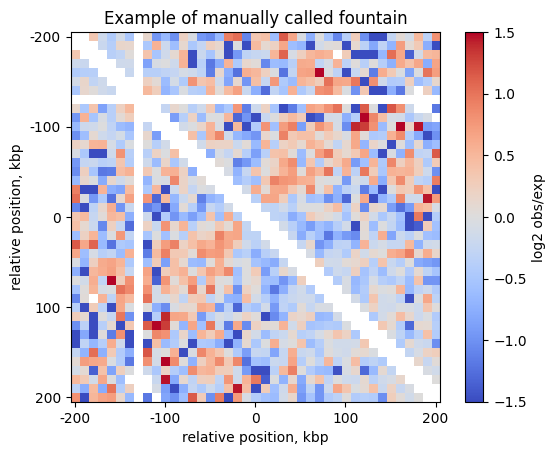

In [6]:
# Visualize some fountain: 
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

FLANK = 200_000
RESOLUTION = 10_000

im = plt.imshow(
    np.log2(stack[:, :, index_fountains[5]]),
    vmax =  1.5,
    vmin = -1.5,
    cmap='coolwarm',
    interpolation=None)

plt.colorbar(label = 'log2 obs/exp')
ticks_pixels = np.linspace(0, FLANK*2//RESOLUTION,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RESOLUTION//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

plt.title("Example of manually called fountain");

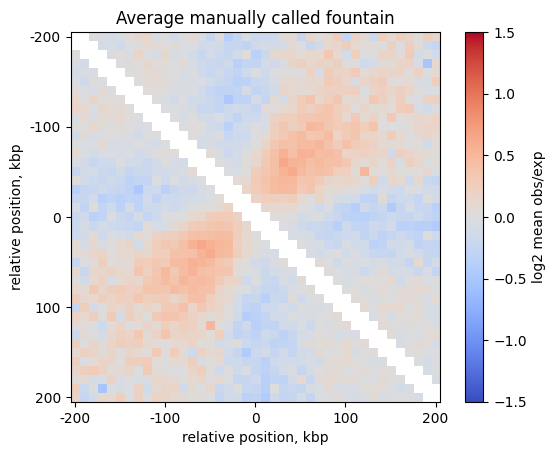

In [7]:
# Visualize fountain average: 
im = plt.imshow(
    np.log2( np.nanmean( stack[:, :, index_fountains], axis=2) ),
    vmax =  1.5,
    vmin = -1.5,
    cmap='coolwarm',
    interpolation=None)

plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = np.linspace(0, FLANK*2//RESOLUTION,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RESOLUTION//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

plt.title("Average manually called fountain");

## 4. Apply pattern mask and obtain the pattern score (fountain score) for each genomic snippet

In [8]:
# Save average fountain: 
average_manual_fountain = np.log2( np.nanmean( stack[:, :, index_fountains], axis=2) );
np.save("./data/fountains/WT.manual.avfountain.npy", average_manual_fountain)

In [ ]:
%%bash
NTHREADS=20
LABEL="WT"
RESOLUTION=10000
MASK_PATH="./data/fountains/WT.manual.avfountain.npy"

fontanka call-mask ./data/cool/${LABEL}.danrer11-reduced.mapq_30.1000.mcool::resolutions/${RESOLUTION} \
        ./data/fountains/${LABEL}.sim.200Kb.output.tsv \
        --snips ./data/fountains/${LABEL}.snippets.npz \
        -W 200_000 -M ${MASK_PATH} \
        --view ./data/danRer11.arms.viewframe.tsv


In [9]:
df_fountains = pd.read_table("./data/fountains/WT.sim.200Kb.output.tsv")

In [10]:
df_fountains.dropna().head()

,Unnamed: 0,chrom,start,end,window_start,window_end,FS,FS_peaks,Scharr_box
21,21,chr1,210000,220000,10000,420000,0.094962,0.244533,40.288462
39,39,chr1,390000,400000,190000,600000,0.173082,0.530144,55.846380
45,45,chr1,450000,460000,250000,660000,-0.060554,0.005180,76.200093
49,49,chr1,490000,500000,290000,700000,0.041717,0.090545,52.168023
52,52,chr1,520000,530000,320000,730000,0.039632,0.041171,52.168023


Visualize the resulting fountain and noise scores: 

In [11]:
# Functions to help with plotting
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import cooltools
import cooltools.lib.plotting
import bioframe
plt.rcParams['font.size'] = 12

def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

(27180000.0, 29660000.0)

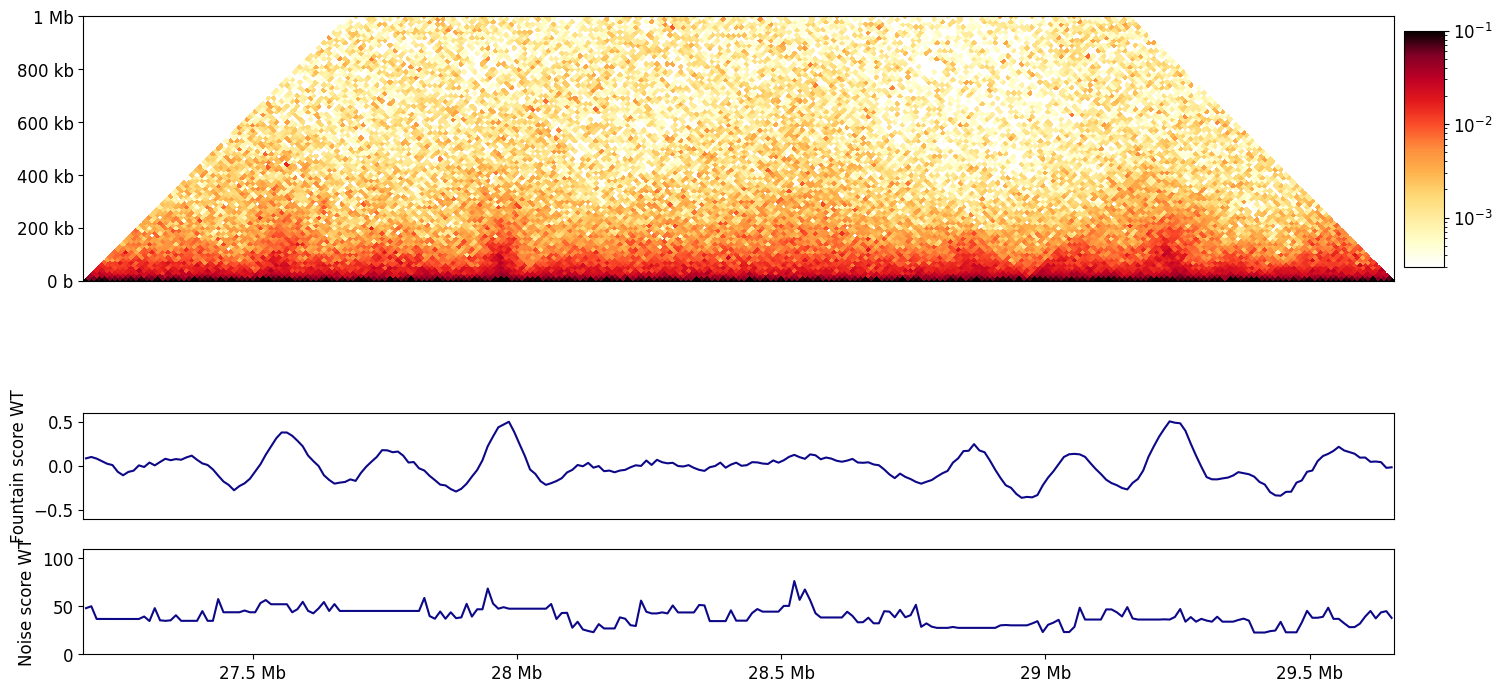

In [12]:
exp = "WT"

start = 27_180_000
end = start + 248 * RESOLUTION
region = ('chr6', start, end)

norm = LogNorm(vmax=0.1, vmin=0.0003)
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(18, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=RESOLUTION, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 100*clr.binsize)
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

FS_region = bioframe.select(df_fountains, region)

FS_ax = divider.append_axes("bottom", size="20%", pad=0., sharex=ax)
FS_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
FS_ax.plot(FS_region[['start', 'end']].mean(axis=1), 
    FS_region["FS"])
FS_ax.set_ylabel(f'Fountain score {exp}')
FS_ax.set_ylim(-0.6, 0.6)
FS_ax.xaxis.set_visible(False)

SS_ax = divider.append_axes("bottom", size="20%", pad=0.3, sharex=ax)
SS_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
SS_ax.plot(FS_region[['start', 'end']].mean(axis=1), 
        FS_region[f'Scharr_box'])
SS_ax.set_ylabel(f'Noise score {exp}')
SS_ax.set_ylim(0, 110)
format_ticks(SS_ax, y=False, rotate=False)

ax.set_xlim(region[1], region[2])

# f.savefig("images_03-07-2022_mainfig/algo.pdf")

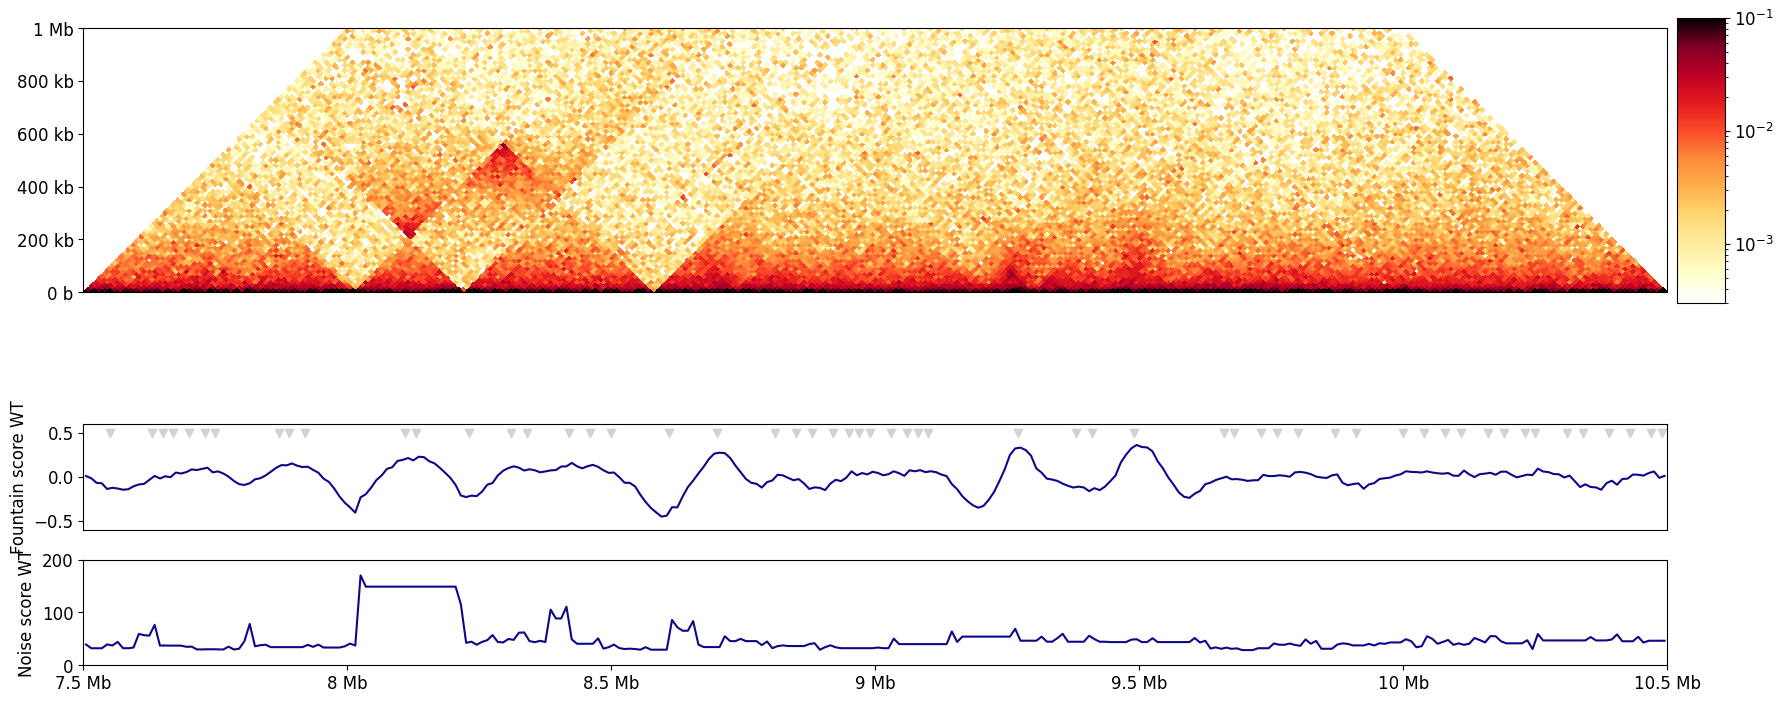

In [13]:
exp = "WT"

# 4_000_000 was good, chr10
# chr18 3 - 8 Mb

start = 7_500_000
end = start + 300*RESOLUTION
region = ('chr24', start, end)

norm = LogNorm(vmax=0.1, vmin=0.0003)
cmap = 'fall'
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(18, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=RESOLUTION, norm=norm, cmap=cmap)
ax.set_aspect(0.5)
ax.set_ylim(0, 100*RESOLUTION)
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1, aspect=6)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)

FS_region = bioframe.select(df_fountains, region)

FS_ax = divider.append_axes("bottom", size="20%", pad=0., sharex=ax)
FS_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
FS_ax.plot(FS_region[['start', 'end']].mean(axis=1), 
    FS_region["FS"])
FS_ax.set_ylabel(f'Fountain score {exp}')
FS_ax.set_ylim(-0.6, 0.6)
FS_ax.xaxis.set_visible(False)

FS_region_peaks = FS_region.dropna(subset='FS_peaks')
for i, r in FS_region_peaks.iterrows():
    FS_ax.scatter(x=r.start, y=0.5, marker='v', color='lightgray', label="All peaks in fountain score")

SS_ax = divider.append_axes("bottom", size="20%", pad=0.3, sharex=ax)
SS_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
SS_ax.plot(FS_region[['start', 'end']].mean(axis=1), 
        FS_region[f'Scharr_box'])
SS_ax.set_ylabel(f'Noise score {exp}')
SS_ax.set_ylim(0, 200)
format_ticks(SS_ax, y=False, rotate=False)

ax.set_xlim(region[1], region[2])

f.tight_layout()

# f.savefig("images_03-07-2022_mainfig/algo.pdf")

### Comparison between manually called and automatically called peaks of fountain score

In [14]:
import seaborn as sns

In [15]:
df_fountains_manual = pd.read_table("./data/WT-manually-called-foutnains.bed", header=None)
df_fountains_manual.columns = ["chrom", "start", "end"]

In [16]:
df_fountains = pd.read_table("./data/fountains/WT.sim.200Kb.output.tsv")

In [17]:
# Filter only trustworthy, good bins: 
df_good_bins = pd.read_table('data/good-bins.50000-safe.danrer11-reduced.tsv')

# Reset numeric columns of non-trustworthy bins to nans:
columns = df_fountains.columns
columns_reset = ['FS', 'FS_peaks', 'Scharr_box']
df_overlap = bioframe.overlap(df_fountains, df_good_bins, 
                     how='left', 
                     return_index=True,
                     suffixes=['', '_'] ).drop_duplicates('index')
df_fountains.loc[pd.isna(df_overlap.start_), columns_reset] = np.nan
df_fountains = df_fountains[columns]

In [18]:
# Allowed offset to call a fountain a hit
offset = 2 * RESOLUTION

In [19]:
df_confirmed = bioframe.overlap( df_fountains_manual, 
                                bioframe.expand(df_fountains.dropna(subset='FS_peaks'), offset), 
                                return_index=True, 
                                how='left' ).sort_values('FS_peaks_').drop_duplicates('index').dropna(subset='chrom_')

In [20]:
df_confirmed.groupby('chrom').count()['start']

chrom
chr1    32
chr2    18
Name: start, dtype: int64

In [21]:
df_fountains_manual.groupby('chrom').count()['start'] # Only one manual fountain was not detected as a peak

chrom
chr1    34
chr2    18
Name: start, dtype: int64

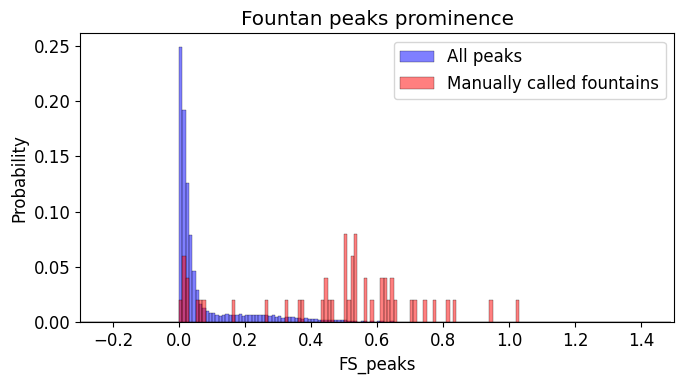

In [22]:
value = "FS_peaks"
title = "Fountan peaks prominence"

plt.figure(figsize=[7, 4])

sns.histplot(df_fountains.dropna(subset="FS_peaks")[value], 
             color='blue', alpha=0.5, stat='probability',
             bins=np.arange(-0.3, 1.5, 0.01), label='All peaks')

sns.histplot(df_confirmed[value+"_"], 
             color='red', alpha=0.5, stat='probability',
             bins=np.arange(-0.3, 1.5, 0.01), label='Manually called fountains')
plt.xlim(-0.3, 1.5)

plt.title(title)
plt.legend()
plt.tight_layout()

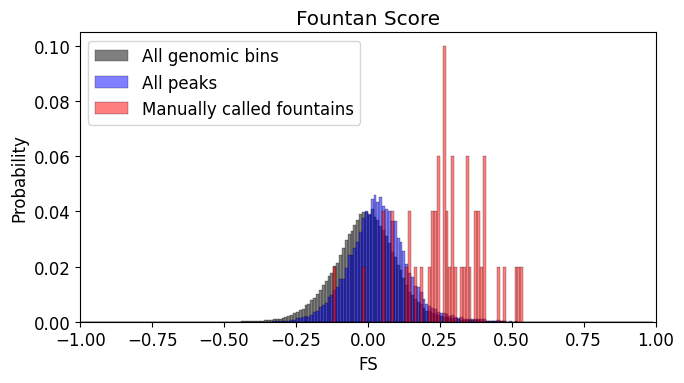

In [23]:
value = "FS"
title = "Fountan Score"

plt.figure(figsize=[7, 4])

sns.histplot(df_fountains[value], 
             color='black', alpha=0.5, stat='probability',
             bins=np.arange(-1.0, 1.0, 0.01), label='All genomic bins')

sns.histplot(df_fountains.dropna(subset="FS_peaks")[value], 
             color='blue', alpha=0.5, stat='probability',
             bins=np.arange(-1.0, 1.0, 0.01), label='All peaks')

sns.histplot(df_confirmed[value+"_"], 
             color='red', alpha=0.5, stat='probability',
             bins=np.arange(-1.0, 1.0, 0.01), label='Manually called fountains')
plt.xlim(-1.0, 1.0)

plt.title(title)
plt.legend()
plt.tight_layout()

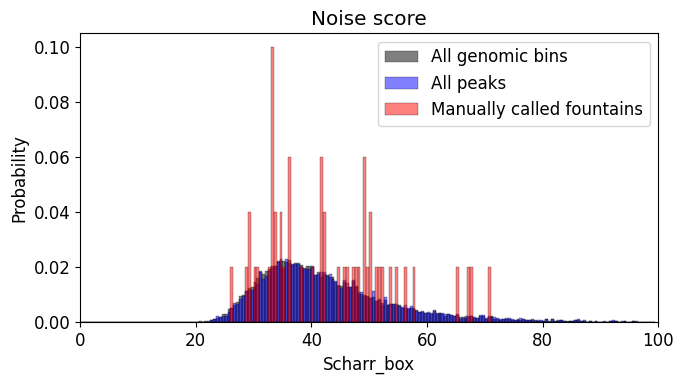

In [24]:
value = "Scharr_box"
title = "Noise score"

plt.figure(figsize=[7, 4])

sns.histplot(df_fountains[value], 
             color='black', alpha=0.5, stat='probability',
             bins=np.arange(0, 100, 0.5), label='All genomic bins')

sns.histplot(df_fountains.dropna(subset="FS_peaks")[value], 
             color='blue', alpha=0.5, stat='probability',
             bins=np.arange(0, 100, 0.5), label='All peaks')

sns.histplot(df_confirmed[value+"_"], 
             color='red', alpha=0.5, stat='probability',
             bins=np.arange(0, 100, 0.5), label='Manually called fountains')

plt.xlim(0, 100)

plt.title(title)
plt.legend()
plt.tight_layout()

### Threshold by peak prominence

In [25]:
# Apply thresholding to cut off huge peak in the distribution on the left: 
from skimage.filters import threshold_li

peak_prominence_th = threshold_li(df_fountains.FS_peaks.values)
print(peak_prominence_th)

0.11002354516001293


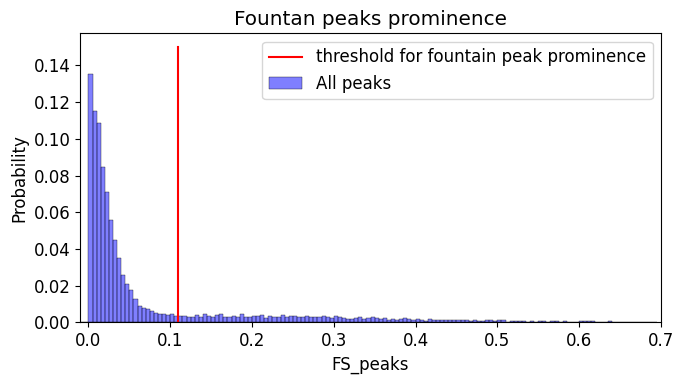

In [26]:
value = "FS_peaks"
title = "Fountan peaks prominence"

plt.figure(figsize=[7, 4])

sns.histplot(df_fountains.dropna(subset="FS_peaks")[value], 
             color='blue', alpha=0.5, stat='probability',
             bins=np.arange(-0.01, 0.7, 0.005), label='All peaks')

plt.plot([peak_prominence_th, peak_prominence_th], [0, 0.15], color='red', label='threshold for fountain peak prominence')

plt.xlim(-0.01, 0.7)

plt.title(title)
plt.legend()
plt.tight_layout()

In [27]:
df_fountains.loc[df_fountains['FS_peaks']<=peak_prominence_th, 'FS_peaks'] = np.nan

In [28]:
df_manual = bioframe.overlap( df_fountains_manual, 
                            bioframe.expand(df_fountains.dropna(subset='FS_peaks'), offset), 
                            return_index=True, 
                            how='left' ).sort_values('FS_peaks_').drop_duplicates('index').dropna(subset='chrom_')

In [29]:
df_manual.groupby('chrom').count()['start']

chrom
chr1    29
chr2    17
Name: start, dtype: int64

### Threshold by fountain score

In [30]:
# require positive correlation
fountain_threshold = 0 

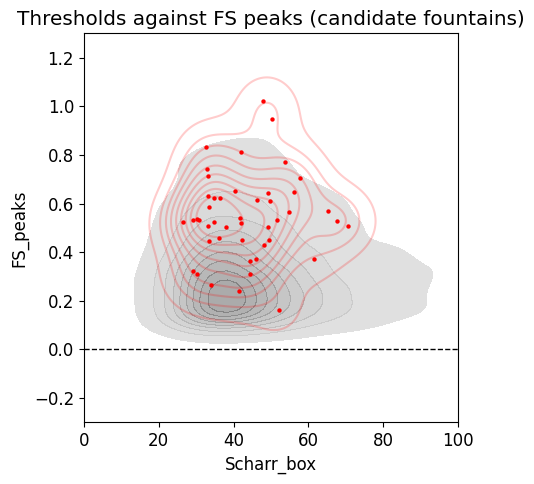

In [31]:
value_x = "Scharr_box"
value_y = "FS_peaks"

plt.figure(figsize=[5, 5])
sns.kdeplot(    data=df_fountains.dropna(subset="FS_peaks"), x=value_x, y=value_y, color='black', alpha=0.5, fill=True)
sns.scatterplot(data=df_manual, x=value_x+"_", y=value_y+"_", color='red', alpha=1, s=10, linewidth=0)
sns.kdeplot(    data=df_manual, x=value_x+"_", y=value_y+"_", color='red', alpha=0.2)

plt.ylim(-0.3, 1.3)
plt.xlim(0, 100)

plt.plot([0, 100], [fountain_threshold, fountain_threshold], 
         '--', color='black', linewidth=1)

plt.title('Thresholds against FS peaks (candidate fountains)')
plt.tight_layout()

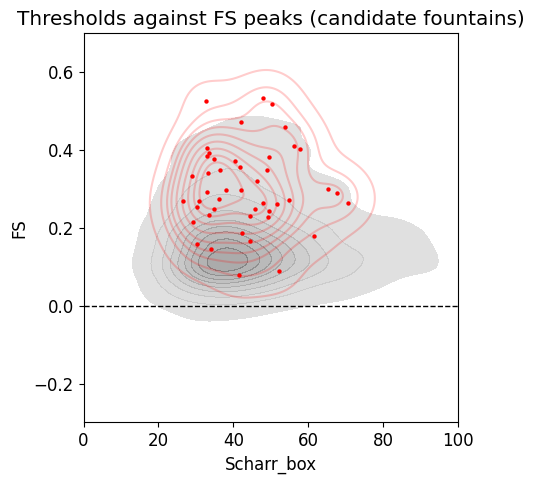

In [32]:
value_x = "Scharr_box"
value_y = "FS"

plt.figure(figsize=[5, 5])
sns.kdeplot(    data=df_fountains.dropna(subset="FS_peaks"), x=value_x, y=value_y, color='black', alpha=0.5, fill=True)
sns.scatterplot(data=df_manual, x=value_x+"_", y=value_y+"_", color='red', alpha=1, s=10, linewidth=0)
sns.kdeplot(    data=df_manual, x=value_x+"_", y=value_y+"_", color='red', alpha=0.2)

plt.ylim(-0.3, 0.7)
plt.xlim(0, 100)

plt.plot([0, 100], [fountain_threshold, fountain_threshold], 
         '--', color='black', linewidth=1)

plt.title('Thresholds against FS peaks (candidate fountains)')
plt.tight_layout()

## 5. Fountain calling for replicates and control experiment (2.75 hpf)

In [34]:
%%bash
NTHREADS=20
FLANK=200000
RESOLUTION=10000
MASK_PATH="./data/fountains/WT.manual.avfountain.npy"

for LABEL in WT1 WT2 Wild-Type_2.75 Wild-Type_2.75_1 Wild-Type_2.75_2
do
    cooltools expected-cis ./data/cool/${LABEL}.danrer11-reduced.mapq_30.1000.mcool::resolutions/${RESOLUTION} \
        --view ./data/danRer11.arms.viewframe.tsv \
        -p $NTHREADS --clr-weight-name weight --ignore-diags 2 \
        -o ./data/expected/${LABEL}.expected.tsv

    cooltools pileup \
        ./data/cool/${LABEL}.danrer11-reduced.mapq_30.1000.mcool::resolutions/${RESOLUTION} ./data/danRer11-reduced.bins.tsv \
        --flank ${FLANK} --features-format BED \
        --view ./data/danRer11.arms.viewframe.tsv \
        --expected ./data/expected/${LABEL}.expected.tsv \
        -p $NTHREADS --clr-weight-name weight --ignore-diags 2 \
        --out-format NPZ --aggregate none --store-snips \
        -o ./data/fountains/${LABEL}.snippets.npz

    fontanka call-mask ./data/cool/${LABEL}.danrer11-reduced.mapq_30.1000.mcool::resolutions/${RESOLUTION} \
            ./data/fountains/${LABEL}.sim.200Kb.output.tsv \
            --snips ./data/fountains/${LABEL}.snippets.npz \
            -W 200_000 -M ${MASK_PATH} \
            --view ./data/danRer11.arms.viewframe.tsv
done

In [35]:
df_good_bins = pd.read_table('data/good-bins.50000-safe.danrer11-reduced.tsv')

In [36]:
dfs = {}
for experiment in ['WT', 'WT1', 'WT2', 'Wild-Type_2.75', 'Wild-Type_2.75_1', 'Wild-Type_2.75_2']:
    
    df = pd.read_table(f"./data/fountains/{experiment}.sim.200Kb.output.tsv").copy()
    
    # Filter only strong peaks:
    th = threshold_li(df.FS_peaks.values)
    df.loc[df['FS_peaks']<=th, 'FS_peaks'] = np.nan

    # Filter only trustworthy, good bins: 
    columns = df.columns
    columns_reset = ['FS', 'FS_peaks', 'Scharr_box']
    df_overlap = bioframe.overlap(df, df_good_bins, 
                         how='left', 
                         return_index=True,
                         suffixes=['', '_'] ).drop_duplicates('index')
    df.loc[pd.isna(df_overlap.start_), columns_reset] = np.nan
    df = df[columns]
    
    df = df.dropna(subset=['FS_peaks'])
    
    dfs[experiment] = df.copy()

In [37]:
def filter_reproducible(df, df_rep, offset):
    df = bioframe.overlap( df, 
                     bioframe.expand(df_rep, offset), 
                     how='left', 
                     return_index=True,
                     suffixes=['', '_'] ).dropna(subset=['chrom_']).drop_duplicates(['chrom', 'start'])
    df = df.set_index('index')
    df = df.drop(['index_'], axis=1)
    df = df[columns]
    print("Confirmed fountains: ", len(df))
    
    return df

In [38]:
# require positive correlation
fountain_threshold = 0 
offset = 2*RESOLUTION

In [39]:
# Reproducible peaks between replicates at 2.75 hpf, where there should not be any signal
# (thus any reproducible peaks are probably rearrangements): 

exp, exp_rep1, exp_rep2 = ('Wild-Type_2.75', 'Wild-Type_2.75_1', 'Wild-Type_2.75_2')

df = dfs[exp].query(f'FS>{fountain_threshold}')
columns = df.columns

df_rep1 = dfs[exp_rep1].query(f'FS>{fountain_threshold}')
df_rep2 = dfs[exp_rep2].query(f'FS>{fountain_threshold}')

df = filter_reproducible(df, df_rep1, offset)
df = filter_reproducible(df, df_rep2, offset)

df_control = df.copy()

Confirmed fountains:  2080
Confirmed fountains:  1131


In [40]:
# Reproducible peaks between the replicates at 5.3 hpf

exp, exp_rep1, exp_rep2 = ('WT', 'WT1', 'WT2')

df = dfs[exp].query(f'FS>{fountain_threshold}')
columns = df.columns

df_rep1 = dfs[exp_rep1].query(f'FS>{fountain_threshold}')
df_rep2 = dfs[exp_rep2].query(f'FS>{fountain_threshold}')

df = filter_reproducible(df, df_rep1, offset)
df = filter_reproducible(df, df_rep2, offset)

df_confirmed = df.copy()

Confirmed fountains:  2817
Confirmed fountains:  2217


In [41]:
columns = df_confirmed.columns
df = bioframe.overlap( df_confirmed, 
             bioframe.expand(df_control, offset), 
             how='left',  
             return_index=True,
             suffixes=['', '_'] ).drop_duplicates(['chrom', 'start'])
df = df.set_index('index')
df = df[df['chrom_'].isna()]
df = df[columns]

df_filtered = df.copy()

In [42]:
# remove top noisy regions
noise_threshold = np.nanpercentile( df_filtered["Scharr_box"], 75 )

df_top = df_filtered.query(f"Scharr_box<{noise_threshold}") 

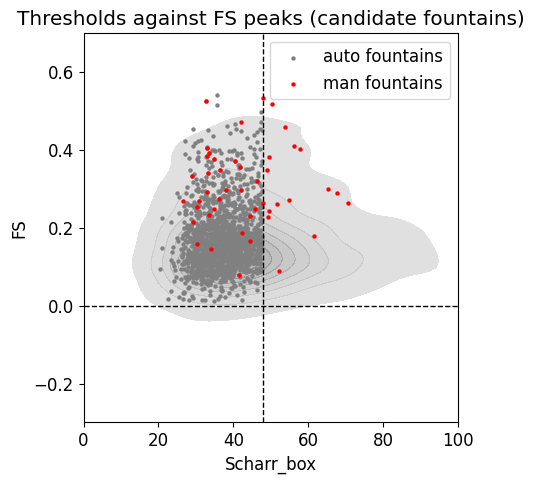

In [44]:
value_x = "Scharr_box"
value_y = "FS"

plt.figure(figsize=[5, 5])
sns.kdeplot(    data=df_fountains.dropna(subset="FS_peaks"), x=value_x, y=value_y, color='black', alpha=0.5, fill=True)
sns.scatterplot(data=df_top, x=value_x, y=value_y, color='grey', alpha=1, s=10, linewidth=0, label='auto fountains')
sns.scatterplot(data=df_manual, x=value_x+"_", y=value_y+"_", color='red', alpha=1, s=10, linewidth=0, label='man fountains')

plt.ylim(-0.3, 0.7)
plt.xlim(0, 100)

plt.plot([0, 100], [fountain_threshold, fountain_threshold], 
         '--', color='black', linewidth=1)
plt.plot([noise_threshold, noise_threshold], [-0.3, 0.7], 
         '--', color='black', linewidth=1)

plt.title('Thresholds against FS peaks (candidate fountains)')
plt.legend()
plt.tight_layout()

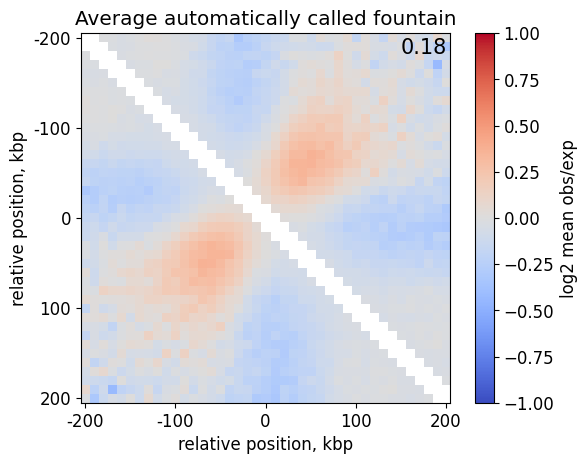

In [45]:
index_fountains = list( df_top.sort_values('FS', ascending=False).index.values )

# Visualize fountain average: 
im = plt.imshow(
    np.log2( np.nanmean( stack[:, :, index_fountains], axis=2) ),
    vmax =  1.0,
    vmin = -1.0,
    cmap='coolwarm',
    interpolation=None)

plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = np.linspace(0, FLANK*2//RESOLUTION,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RESOLUTION//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

score = np.nanmean(df_top['FS'])
plt.text(35.0, 0.0, f"{score:.2f}", 
    horizontalalignment='left', 
    verticalalignment='top', 
    fontsize=15)

plt.title("Average automatically called fountain");

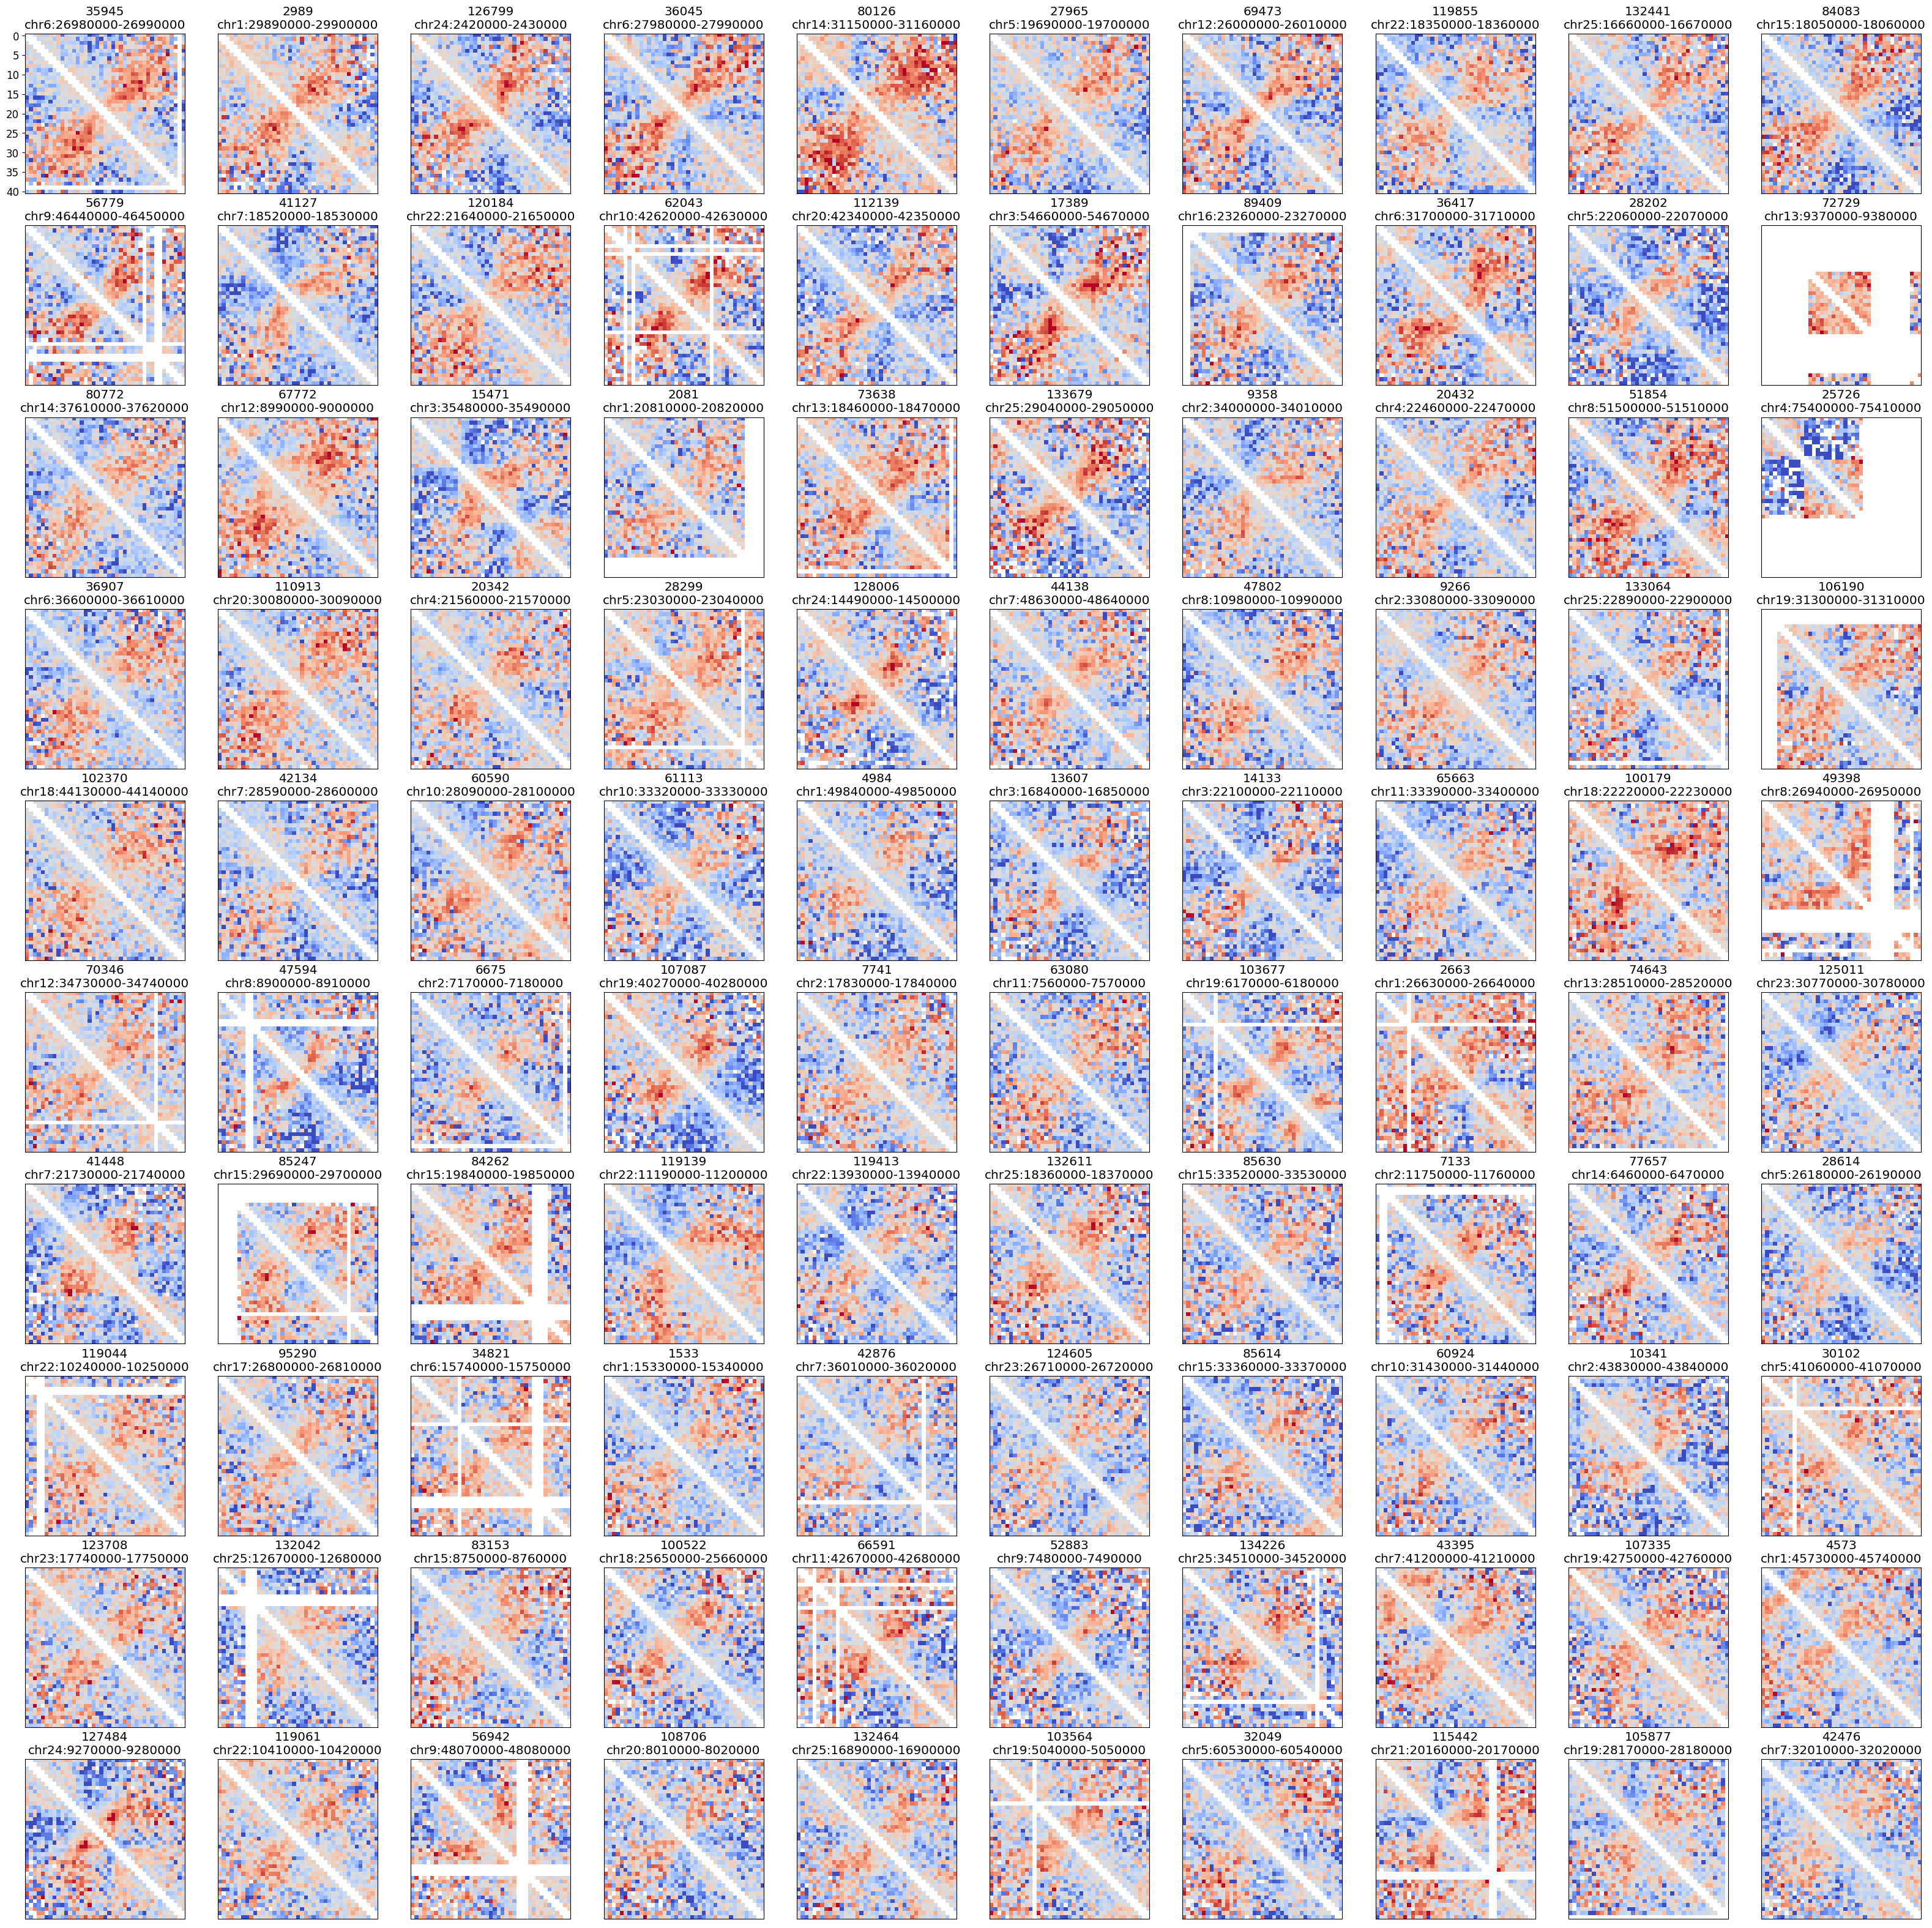

In [46]:
idx_selected = index_fountains[:100]
nrows = len(idx_selected)//10 # n_samples_show
ncols = 10

fig, axes = plt.subplots(nrows, ncols, figsize=[4*ncols, 4*nrows])

for i, idx in enumerate(idx_selected):
    
    ax = axes.flatten()[i]
    
    mtx = stack[:, :, idx]
    img = ax.matshow(
        np.log2(mtx),  
        vmin=-1.75,
        vmax=1.75,
        cmap='coolwarm',
        interpolation=None
    );
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)

    ax.xaxis.set_visible(False)
    
    ax.minorticks_off()
    reg = bins.loc[idx, ['chrom', 'start', 'end']]
    ax.set_title(f"{idx}\n{reg.chrom}:{reg.start}-{reg.end}");
    
    ticks_pixels = np.linspace(0, FLANK*2//RESOLUTION,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RESOLUTION//1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')
    
plt.show();